In [594]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as stats
import csv
import statsmodels.api as sm 
import pylab as py
import scipy
from scipy.stats import kstest
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import seaborn as sns
from scipy.stats import laplace
from scipy.stats import levene
from statsmodels.stats.diagnostic import lilliefors


## Analiza jednowymiarowa
### EUR - USD
#### dane i wykres:


In [595]:
data = pd.read_csv("USD_EUR.csv")
data['Ostatnio'] = data['Ostatnio'].str.replace(',', '.').astype(float)
data['Data'] = data['Data'].str.replace('.', '-')
data['Data'] = pd.to_datetime(data['Data'], format='%d-%m-%Y')
data.head()

C:\Users\negul\AppData\Local\Temp\ipykernel_35652\499437564.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Data'] = data['Data'].str.replace('.', '-')


,Data,Ostatnio,Otwarcie,Max.,Min.,Wol.,Zmiana%
0,2024-04-19,0.9384,"0,9395","0,9425","0,9365",NaN,"-0,11%"
1,2024-04-18,0.9394,"0,9370","0,9398","0,9354",NaN,"0,28%"
2,2024-04-17,0.9368,"0,9416","0,9429","0,9363",NaN,"-0,50%"
3,2024-04-16,0.9415,"0,9413","0,9434","0,9385",NaN,"0,04%"
4,2024-04-15,0.9411,"0,9401","0,9416","0,9376",NaN,"0,19%"


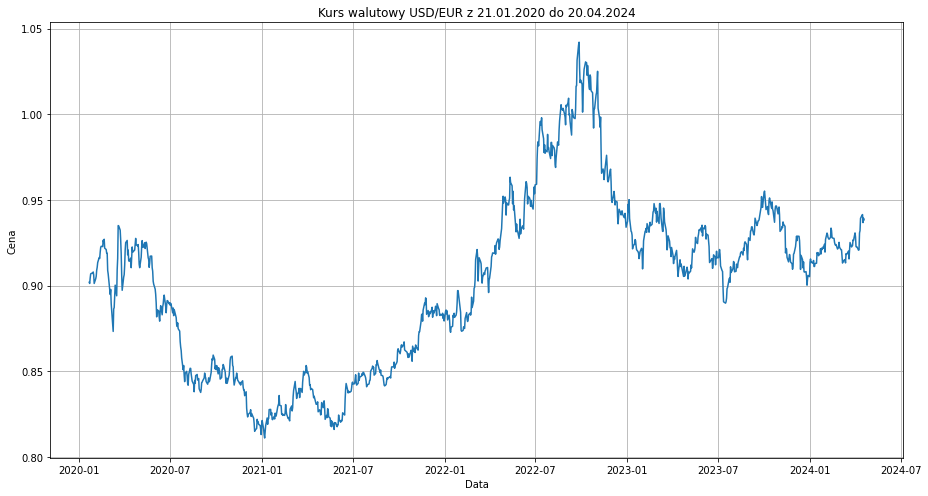

In [596]:
plt.figure(figsize=[13,7])
plt.title('Kurs walutowy USD/EUR z 21.01.2020 do 20.04.2024')
plt.plot(data['Data'], data['Ostatnio'])
plt.xlabel('Data')
plt.ylabel('Cena')
plt.grid(True)
plt.tight_layout()
plt.savefig('Kurs_walutowy_USD_EUR.png')


### Zmiana kursu (stopa logarytmiczna)

In [597]:
data["d_after"] = data["Ostatnio"].shift(-1)
data = data.fillna(data["Ostatnio"].iloc[-1])
data['log_return'] = np.log(data['d_after']/data['Ostatnio'])
data = data.drop(data.index[-1])
data['log_return'].tail()

1103    0.000331
1104   -0.000551
1105   -0.002650
1106   -0.003544
1107    0.000776
Name: log_return, dtype: float64

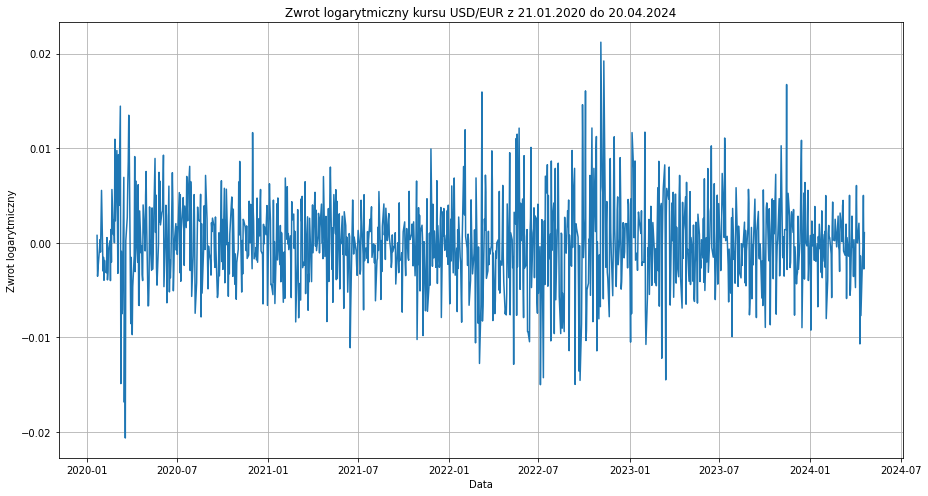

In [598]:
plt.figure(figsize=[13,7])
plt.title('Zwrot logarytmiczny kursu USD/EUR z 21.01.2020 do 20.04.2024')
plt.plot(data['Data'], data['log_return'])
plt.xlabel('Data')
plt.ylabel('Zwrot logarytmiczny')
plt.grid(True)
plt.savefig('Zwrot_USD_EUR.png')
plt.tight_layout()


### Miary zmienności

In [599]:
print("Średnia = ", np.mean(data['log_return']))
print("Odchylenie standardowe = ", np.std(data['log_return']))
print("Variancja = ", np.var(data['log_return']))
print("Rozstęp = ", np.ptp(data['log_return']))

odchylenie_przecietne = np.mean(np.abs(data['log_return'] - np.mean(data['log_return'])))
print("Odchylenie przeciętne = ", odchylenie_przecietne)

srednia = np.mean(data['log_return'])
odchylenie_standardowe = np.std(data['log_return'], ddof=1)  # ddof=1 oznacza, że obliczamy próbkę
wspolczynnik_zmiennosci = (odchylenie_standardowe / srednia) * 100
print("Współczynnik zmienności = ", wspolczynnik_zmiennosci)


Średnia =  -3.570557515942187e-05
Odchylenie standardowe =  0.0048006503895878915
Variancja =  2.3046244163050373e-05
Rozstęp =  0.041833744064359316
Odchylenie przeciętne =  0.0036375793830693047
Współczynnik zmienności =  -13451.171684322358


### Kwantyle

In [600]:
print("Wartóść minimalna = ", min(data['log_return']))
print("Kwartyl 0.05 = ", np.quantile(data['log_return'], 0.05))
print("Kwartyl 0.25 = ", np.quantile(data['log_return'], 0.25))
print("Mediana = ", np.quantile(data['log_return'], 0.5))
print("Kwartyl 0.75 = ", np.quantile(data['log_return'], 0.75))
print("Kwartyl 0.95 = ", np.quantile(data['log_return'], 0.95))
print("Wartóść maxymalna = ", max(data['log_return']))

Q1 = np.quantile(data['log_return'], 0.25)
Q3 = np.quantile(data['log_return'], 0.75)
rozstep_miedzykwartylowy = Q3 - Q1
print("Rozstęp międzykwartylowy = ", rozstep_miedzykwartylowy)


Wartóść minimalna =  -0.02063711076727081
Kwartyl 0.05 =  -0.007687015884204237
Kwartyl 0.25 =  -0.002816407453172539
Mediana =  0.0
Kwartyl 0.75 =  0.0027897448748643366
Kwartyl 0.95 =  0.007859800926109326
Wartóść maxymalna =  0.021196633297088506
Rozstęp międzykwartylowy =  0.005606152328036875


### Histogram oraz gęstość empiryczna:

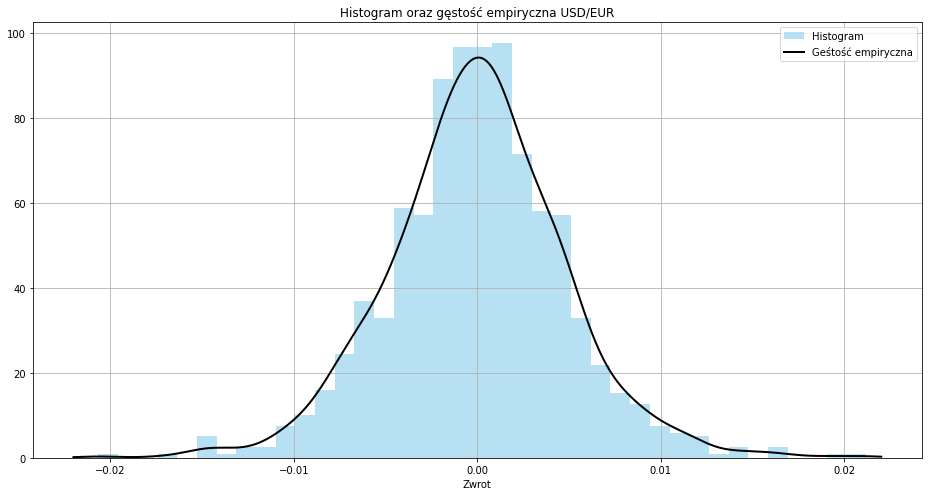

In [601]:
plt.figure(figsize=[13,7])

# Histogram
plt.hist(data['log_return'], bins='auto', density=True, alpha=0.6, color='skyblue', label='Histogram')

#Gestość
kde = stats.gaussian_kde(data['log_return'])
x = np.linspace(-0.022, 0.022, 10000)
plt.plot(x, kde(x), 'k-', linewidth=2, label = 'Geśtość empiryczna')

plt.title('Histogram oraz gęstość empiryczna USD/EUR')
plt.xlabel('Zwrot')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('hist_USD_EUR.png')

### Dystrybuanta empiryczna:

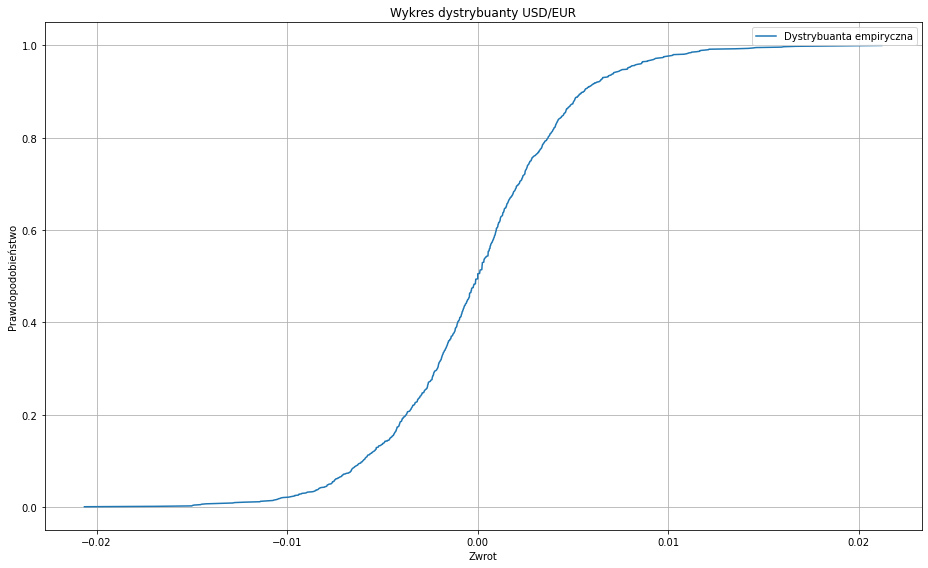

In [602]:
plt.figure(figsize=(13, 8))
dystrybemp=ECDF(data['log_return'])
plt.plot(dystrybemp.x, dystrybemp.y, label="Dystrybuanta empiryczna")
plt.title('Wykres dystrybuanty USD/EUR')
plt.xlabel('Zwrot')
plt.ylabel('Prawdopodobieństwo')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('Dyst_emp_USD_EUR.png')

### Dopasowanie:


In [603]:
# Wartość krytyczna
alpha = 0.05
n = len(data['log_return'])
critical_value = np.sqrt(-0.5 * np.log(alpha / 2)) / np.sqrt(n)

# Dopasowanie rozkładów
params_normal = stats.norm.fit(data['log_return'])
params_t = stats.t.fit(data['log_return'])  
params_laplace = stats.laplace.fit(data['log_return'])  
params_cauchy = stats.cauchy.fit(data['log_return'])   
params_lognorm = stats.lognorm.fit(data['log_return']) 

# Test Kołmogorowa-Smirnowa
ks_stat_t, ks_p_t = stats.kstest(data['log_return'], 't', args=params_t)
ks_stat_laplacea, ks_p_laplacea = stats.kstest(data['log_return'], 'laplace', args=params_laplace)
ks_stat_cauchy, ks_p_cauchy = stats.kstest(data['log_return'], 'cauchy', args=params_cauchy)
ks_stat_lognorm, ks_p_lognorm = stats.kstest(data['log_return'], 'lognorm', args=params_lognorm)
ks_stat_norm, ks_p_norm = stats.kstest(data['log_return'], 'norm', args=params_normal)

# Test Shapiro-Wilka
w_statistic_normal, p_value_normal = stats.shapiro(data['log_return'])

print("T-studenta: KS-statystyka =", ks_stat_t, "P-wartość =", ks_p_t)
print("Laplace\'a: KS-statystyka =", ks_stat_laplacea, "P-wartość =", ks_p_laplacea)
print("Cauchy: KS-statystyka =", ks_stat_cauchy, "P-wartość =", ks_p_cauchy)
print("Lognorm: KS-statystyka =", ks_stat_lognorm, "P-wartość =", ks_p_lognorm)
print("Normalny: KS-statystyka =", ks_stat_norm, "P-wartość =", ks_p_norm)
print("Normalny: W-statystyka =", w_statistic_normal, "P-wartość =", p_value_normal)
print(critical_value)

T-studenta: KS-statystyka = 0.01456496769228921 P-wartość = 0.970150608822791
Laplace'a: KS-statystyka = 0.03185240895505603 P-wartość = 0.20648092839787335
Cauchy: KS-statystyka = 0.06231592297311275 P-wartość = 0.00034933079608888456
Lognorm: KS-statystyka = 0.0378931758166704 P-wartość = 0.0809029569045564
Normalny: KS-statystyka = 0.03590392827482358 P-wartość = 0.11215825714780558
Normalny: W-statystyka = 0.9894370436668396 P-wartość = 3.744802370420075e-07
0.04080020580061717


In [604]:

# Dopasowanie rozkładów
params_normal = stats.norm.fit(data['log_return'])
params_t = stats.t.fit(data['log_return'])  

# Test Kołmogorowa-Smirnowa
ks_stat_t, ks_p_t = stats.kstest(data['log_return'], 't', args=params_t)
# Test Shapiro-Wilka
w_statistic_normal, p_value_normal = stats.shapiro(data['log_return'])

print("T-studenta: KS-statystyka =", ks_stat_t, "P-wartość =", ks_p_t)
print("Normalny: W-statystyka =", w_statistic_normal, "P-wartość =", p_value_normal)



T-studenta: KS-statystyka = 0.01456496769228921 P-wartość = 0.970150608822791
Normalny: W-statystyka = 0.9894370436668396 P-wartość = 3.744802370420075e-07


Z pewnością wybieramy rozkład **t-studenta**, bo p-wartość dla tego rozkładu jest więkrza, ponadto p-wartość w tescie shapiro-wilka jest mniej niż  0.05 (poziom istotności), co wskazuje na odrzucenie hipotezy zerowej, sugerując, że dane nie są normalnie rozłożone. Parametry dla dopasowanego rozkładu t-studenta:

In [605]:
params_t

(6.882327529826087, -3.997350710514041e-05, 0.004061272343711721)

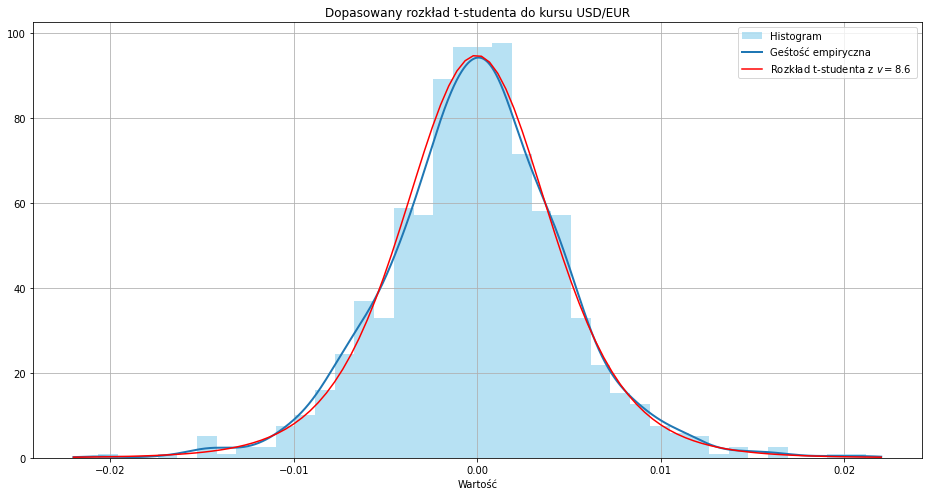

In [606]:
mu = np.mean(data['log_return'])
sigma = np.std(data['log_return'])

plt.figure(figsize=[13,7])

# Histogram
plt.hist(data['log_return'], bins='auto', density=True, alpha=0.6, color='skyblue', label='Histogram')

#Gestość
kde = stats.gaussian_kde(data['log_return'])
x = np.linspace(-0.022, 0.022, 10000)
plt.plot(x, kde(x), linewidth=2, label = 'Geśtość empiryczna')

# gęstość teoretyczna
pdf = stats.t.pdf(np.linspace(-0.022, 0.022, 100), params_t[0], params_t[1], params_t[2])
plt.plot(np.linspace(-0.022, 0.022, 100), pdf, label = r"Rozkład t-studenta z $v = 8.6$ ", color = 'red')

plt.title('Dopasowany rozkład t-studenta do kursu USD/EUR')
plt.xlabel('Wartość')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('hist_teo_USD_EUR.png')

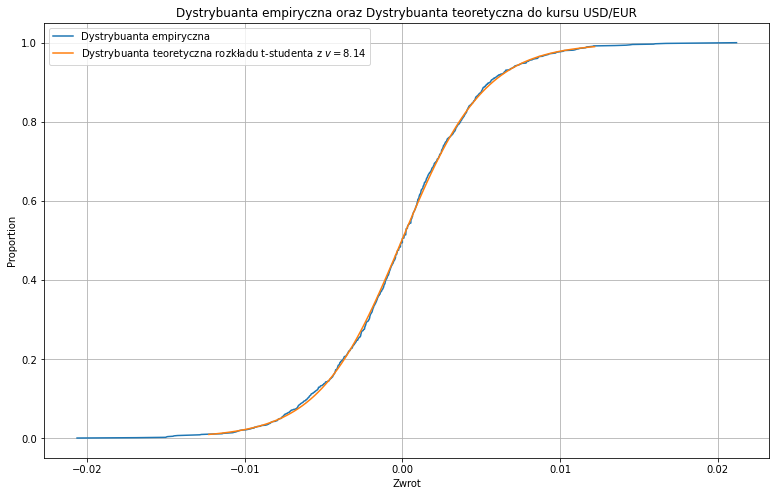

In [607]:
plt.figure(figsize=(13, 8))
plt.plot(dystrybemp.x, dystrybemp.y, label="Dystrybuanta empiryczna")

x = np.linspace(stats.t.ppf(0.01, params_t[0], params_t[1], params_t[2]), stats.t.ppf(0.99,params_t[0], params_t[1], params_t[2]), 100)
plt.plot(x, stats.t.cdf(x,params_t[0], params_t[1], params_t[2]),label=r"Dystrybuanta teoretyczna rozkładu t-studenta z $v = 8.14$")

plt.xlabel('Zwrot')
plt.ylabel('Proportion')
plt.title("Dystrybuanta empiryczna oraz Dystrybuanta teoretyczna do kursu USD/EUR")
plt.legend()
plt.grid(True)
plt.savefig('Dyst_teo_USD_EUR.png')
plt.show()

### USD - YUAN


In [608]:
df = pd.read_csv("USD_YUAN.csv")
df['Date'] = df['Date'].str.replace('/', '-')
df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%y')

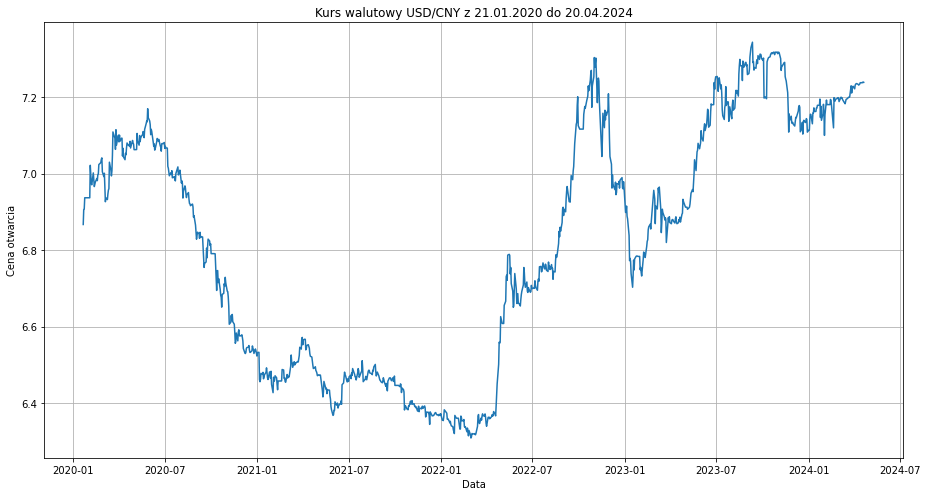

In [609]:
dane = []
zmiana = []
zmiana_licz = []
dane = []
zmiana = []
zmiana_licz = []
dataa = df['Date']
cena_otw = []
with open('USD_YUAN.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
      dane.append(lines[1])
      cena_otw.append(lines[1])

dane = dane [1:] 
cena_otw = cena_otw[1:]
cena_otw_l = []
for z in cena_otw:
    cena_otw_l.append(float(z))
   

for i in dane:
    zmiana.append(float(i))

for k in range(len(zmiana)-1):
        zmiana_licz.append( np.log(zmiana[k+1]/zmiana[k]) )

plt.figure(figsize=[13,7])
plt.plot(dataa,cena_otw_l)
plt.title("Kurs walutowy USD/CNY z 21.01.2020 do 20.04.2024")
plt.ylabel("Cena otwarcia")
plt.xlabel('Data')
plt.grid(True)
plt.tight_layout()
plt.savefig('Kurs_walutowy_USD_YUAN.png')
plt.show()

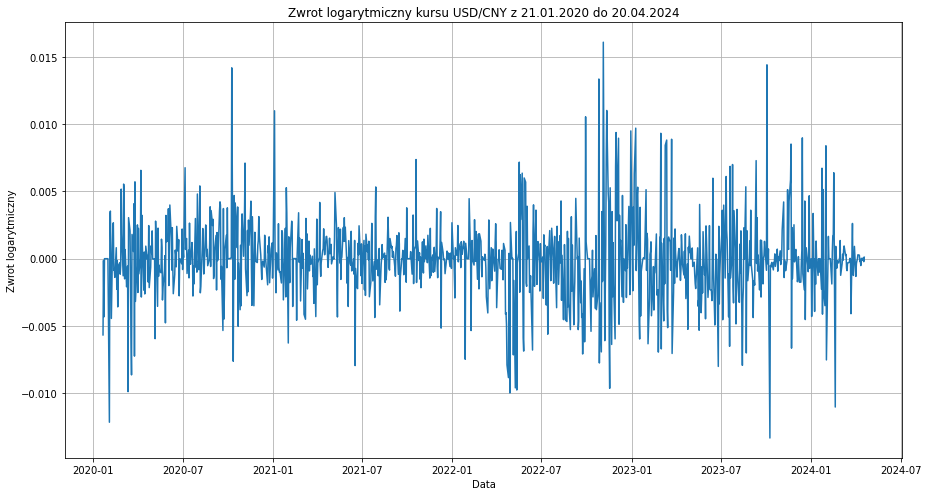

In [610]:
dataa = dataa [1:] 
plt.figure(figsize=[13,7])
plt.plot(dataa, zmiana_licz)
plt.title("Zwrot logarytmiczny kursu USD/CNY z 21.01.2020 do 20.04.2024")
plt.ylabel("Zwrot logarytmiczny")
plt.xlabel('Data')
plt.grid(True)
plt.tight_layout()
plt.savefig('Zwrot_USD_YUAN.png')
plt.show()

### ACF

<Figure size 936x504 with 0 Axes>

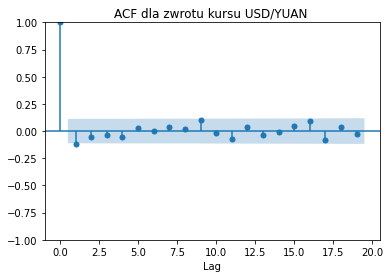

In [611]:
zmiana_licz = np.array(zmiana_licz)
acf,confidence_interval=sm.tsa.acf(zmiana_licz[0:310],nlags=zmiana_licz[0:310].shape[0]-1,alpha=0.05,fft=False)

plt.figure(figsize=[13,7])
plot_acf(zmiana_licz[0:310],lags=[i for i in range(0,20)])
plt.title("ACF dla zwrotu kursu USD/YUAN ")
plt.xlabel("Lag")
plt.show()

### Histogram

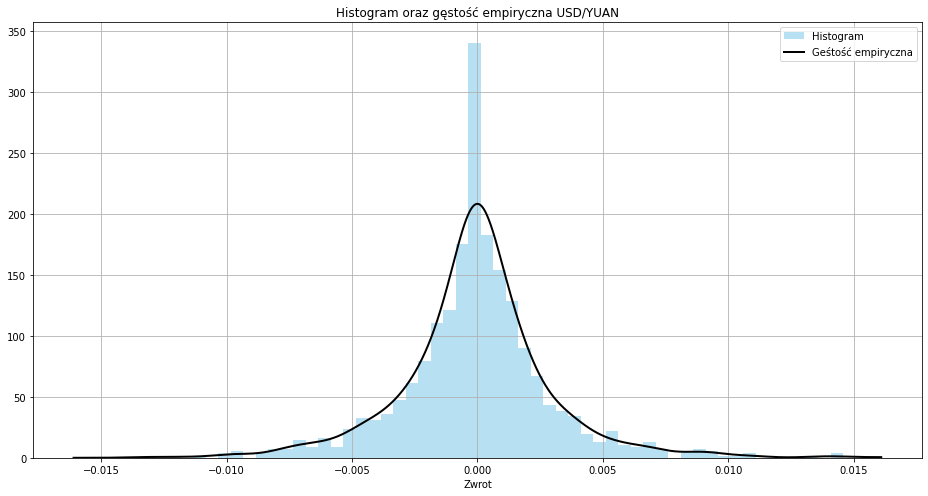

In [612]:
plt.figure(figsize=[13,7])

# Histogram
plt.hist(zmiana_licz, bins='auto', density=True, alpha=0.6, color='skyblue', label='Histogram')

#Gestość
kde = stats.gaussian_kde(zmiana_licz)
x = np.linspace(-0.0161, 0.0161, 10000)
plt.plot(x, kde(x), 'k-', linewidth=2, label = 'Geśtość empiryczna')

plt.title('Histogram oraz gęstość empiryczna USD/YUAN')
plt.xlabel('Zwrot')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('Hist_USD_YUAN.png')
plt.show()

### Dystrybuanta

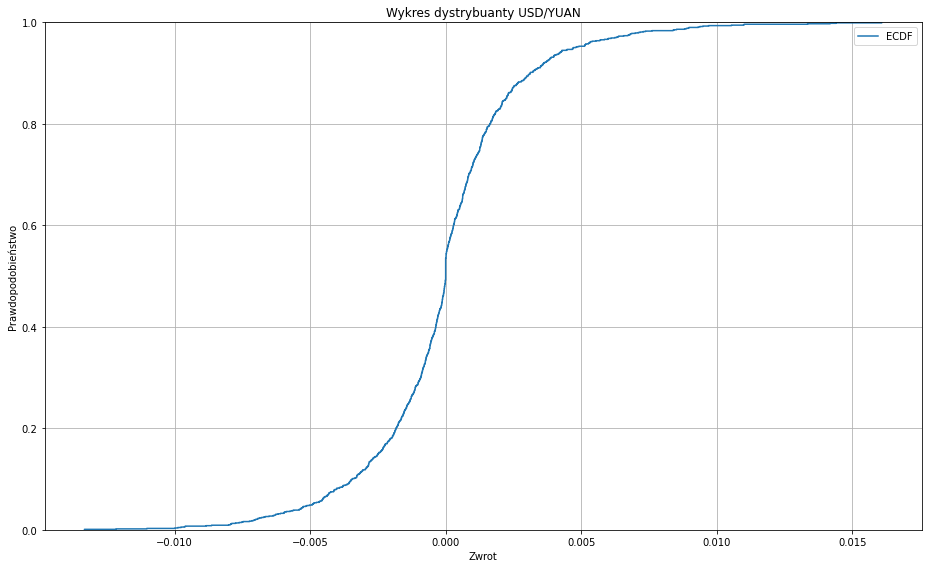

In [613]:
plt.figure(figsize=(13, 8))
sns.ecdfplot(data=zmiana_licz,label="ECDF")
plt.xlabel("Zwrot")
plt.title('Wykres dystrybuanty USD/YUAN')
plt.ylabel('Prawdopodobieństwo')
plt.grid(True)
plt.legend()
plt.savefig('Dyst_emp_USD_YUAN.png')
plt.tight_layout()

### Dopasowanie

In [614]:
args = scipy.stats.laplace.fit(zmiana_licz[0:310])
print(kstest(zmiana_licz[0:310],'laplace',args=args))
print(f"Parametry rozkładu Laplace'a: {args}")

KstestResult(statistic=0.07250809795005009, pvalue=0.07306705673624425)
Parametry rozkładu Laplace'a: (-0.00016494584695011884, 0.002048351891566553)


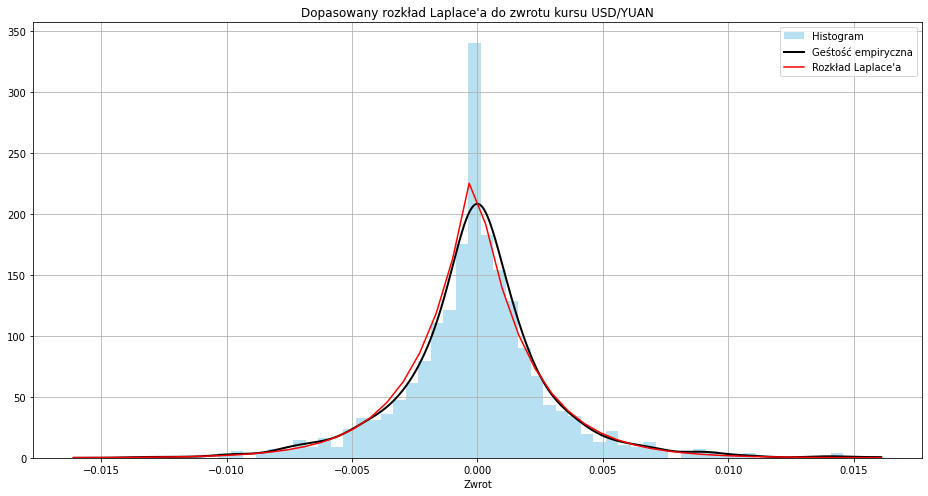

In [615]:
plt.figure(figsize=[13,7])

# Histogram
plt.hist(zmiana_licz, bins='auto', density=True, alpha=0.6, color='skyblue', label='Histogram')

#Gestość
kde = stats.gaussian_kde(zmiana_licz)
x = np.linspace(-0.0161, 0.0161, 10000)
plt.plot(x, kde(x), 'k-', linewidth=2, label = 'Geśtość empiryczna')

#Gęstość teoretyczna
x = np.linspace(-0.0161,0.0161)
plt.plot(x,laplace.pdf(x,args[0],args[1]),color = 'red', label='Rozkład Laplace\'a')

plt.title('Dopasowany rozkład Laplace\'a do zwrotu kursu USD/YUAN')
plt.xlabel('Zwrot')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('histdop_USD_YUAN.png')

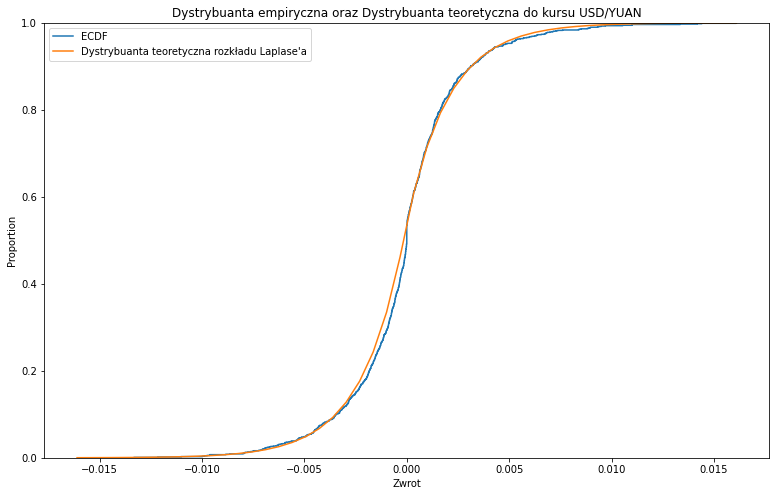

In [616]:
plt.figure(figsize=(13, 8))
sns.ecdfplot(data=zmiana_licz,label="ECDF")

plt.plot(x,laplace.cdf(x,args[0],args[1]),label='Dystrybuanta teoretyczna rozkładu Laplase\'a')

plt.xlabel('Zwrot')
plt.title("Dystrybuanta empiryczna oraz Dystrybuanta teoretyczna do kursu USD/YUAN")
plt.legend()
plt.savefig('Dyst_teo_USD_YUAN.png')
plt.show()

In [617]:
for i in range(10):    
    print(sm.stats.acorr_ljungbox(zmiana_licz, lags=[i+1], return_df=True))

    lb_stat  lb_pvalue
1  2.442734    0.11807
    lb_stat  lb_pvalue
2  3.108339   0.211365
    lb_stat  lb_pvalue
3  3.464388    0.32541
    lb_stat  lb_pvalue
4  3.475008   0.481689
   lb_stat  lb_pvalue
5  5.12207   0.401165
    lb_stat  lb_pvalue
6  5.715996   0.455744
     lb_stat  lb_pvalue
7  11.823403   0.106518
     lb_stat  lb_pvalue
8  11.986381   0.151813
     lb_stat  lb_pvalue
9  12.171926    0.20379
      lb_stat  lb_pvalue
10  12.603991   0.246663


### Miary zmienności

In [618]:
print("Średnia = ", np.mean(zmiana_licz))
print("Odchylenie standardowe = ", np.std(zmiana_licz))
print("Variancja = ", np.var(zmiana_licz))
print("Rozstęp = ", np.ptp(zmiana_licz))

odchylenie_przecietne = np.mean(np.abs(zmiana_licz - np.mean(zmiana_licz)))
print("Odchylenie przeciętne = ", odchylenie_przecietne)

srednia = np.mean(zmiana_licz)
odchylenie_standardowe = np.std(zmiana_licz, ddof=1)  # ddof=1 oznacza, że obliczamy próbkę
wspolczynnik_zmiennosci = (odchylenie_standardowe / srednia) * 100
print("Współczynnik zmienności = ", wspolczynnik_zmiennosci)

Średnia =  -4.752688589322959e-05
Odchylenie standardowe =  0.002999503629296043
Variancja =  8.997022022160132e-06
Rozstęp =  0.029406458932533512
Odchylenie przeciętne =  0.0020098389523984976
Współczynnik zmienności =  -6314.022171723605


### Kwantyle

In [619]:
print("Wartóść minimalna = ", min(zmiana_licz))
print("Kwartyl 0.05 = ", np.quantile(zmiana_licz, 0.05))
print("Kwartyl 0.25 = ", np.quantile(zmiana_licz, 0.25))
print("Mediana = ", np.quantile(zmiana_licz, 0.5))
print("Kwartyl 0.75 = ", np.quantile(zmiana_licz, 0.75))
print("Kwartyl 0.95 = ", np.quantile(zmiana_licz, 0.95))
print("Wartóść maxymalna = ", max(zmiana_licz))

Q1 = np.quantile(zmiana_licz, 0.25)
Q3 = np.quantile(zmiana_licz, 0.75)
rozstep_miedzykwartylowy = Q3 - Q1
print("Rozstęp międzykwartylowy = ", rozstep_miedzykwartylowy)

Wartóść minimalna =  -0.013322394030620101
Kwartyl 0.05 =  -0.004902910815838149
Kwartyl 0.25 =  -0.0013626170765393389
Mediana =  0.0
Kwartyl 0.75 =  0.0012589584018373704
Kwartyl 0.95 =  0.004704270364353183
Wartóść maxymalna =  0.01608406490191341
Rozstęp międzykwartylowy =  0.002621575478376709


## Ryzyko ekstrymalne dla USD - YUAN

In [620]:
przek_ = []
for i in zmiana_licz:
    if i > 0.004704270364353183:
        przek_.append(i)
x= np.linspace(0.0001,0.015)
args = scipy.stats.genpareto.fit(np.array(przek_)-0.004704270364353183)

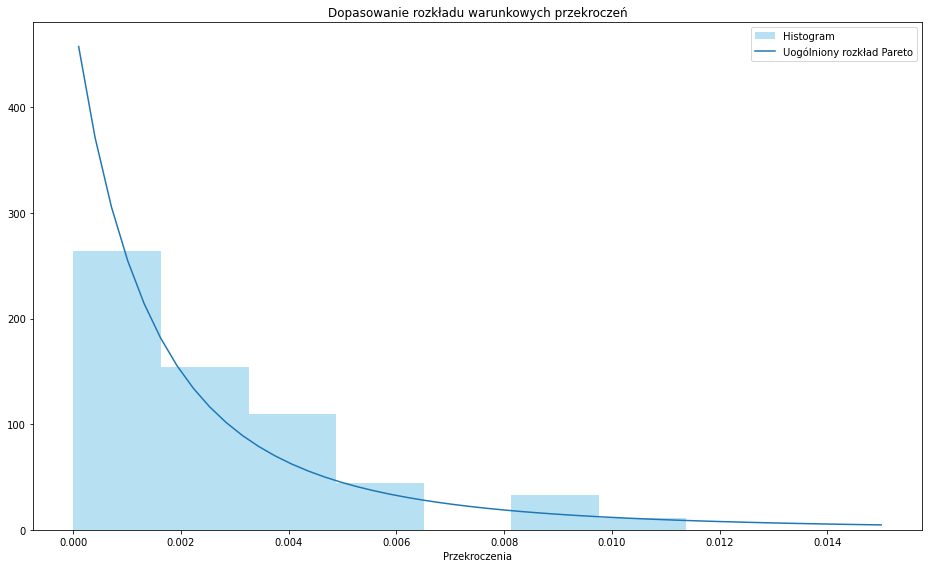

In [621]:
plt.figure(figsize=(13, 8))
plt.hist(np.array(przek_)-0.004704270364353183, bins='auto', density=True, alpha=0.6, color='skyblue', label='Histogram')
plt.plot(x,scipy.stats.genpareto.pdf(x,args[0],args[1],args[2]),label='Uogólniony rozkład Pareto')
plt.title('Dopasowanie rozkładu warunkowych przekroczeń')
plt.xlabel("Przekroczenia")
plt.tight_layout()
plt.legend()
plt.savefig('przek.png')
plt.show()

## Testowanie wsteczne

### USD - YUAN

In [622]:
dane = df[' Open']
gr1 = dane[:590]
gr2 = dane[590:]

w_stats, p_value = levene(gr1, gr2,
                          center='mean')
w_stats, p_value

(0.3441986700374992, 0.5575352551703338)

### EUR - USD

In [623]:
test_wstecz = data['Ostatnio']
gr1 = test_wstecz[:554]
gr2 = test_wstecz[554:]

w_stats, p_value = levene(gr1, gr2,
                          center='mean')
w_stats, p_value

(6.862873201981316, 0.008920984070525242)

## Analiza wielowymiarowa

portfel = 0.7 USD/YUAN + 0.3 USD/EUR

In [624]:
df.head()

,Date,Open,High,Low,Close
0,2024-04-19,7.2382,7.2430,7.2368,7.2398
1,2024-04-18,7.2390,7.2397,7.2334,7.2382
2,2024-04-17,7.2374,7.2405,7.2338,7.2390
3,2024-04-16,7.2379,7.2405,7.2336,7.2374
4,2024-04-15,7.2370,7.2389,7.2364,7.2380


In [625]:
data['Portfel'] = 0.7*df[' Open'] + 0.3*data['Ostatnio']
data['Portfel'].head()

0    5.34826
1    5.34912
2    5.34722
3    5.34898
4    5.34823
Name: Portfel, dtype: float64

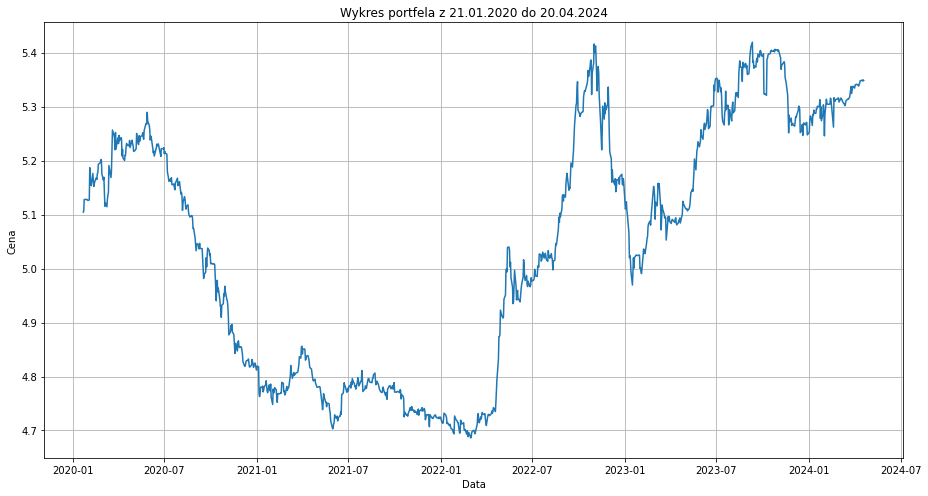

In [626]:
plt.figure(figsize=[13,7])
plt.title('Wykres portfela z 21.01.2020 do 20.04.2024')
plt.plot(data['Data'], data['Portfel'])
plt.xlabel('Data')
plt.ylabel('Cena')
plt.grid(True)
plt.tight_layout()

In [627]:
data["d_after"] = data["Portfel"].shift(-1)
data = data.fillna(data["Portfel"].iloc[-1])
data['Zwrot'] = np.log(data['d_after']/data['Portfel'])
#data = data.drop(data.index[-1])
data['Zwrot'].head()


0    0.000161
1   -0.000355
2    0.000329
3   -0.000140
4   -0.000075
Name: Zwrot, dtype: float64

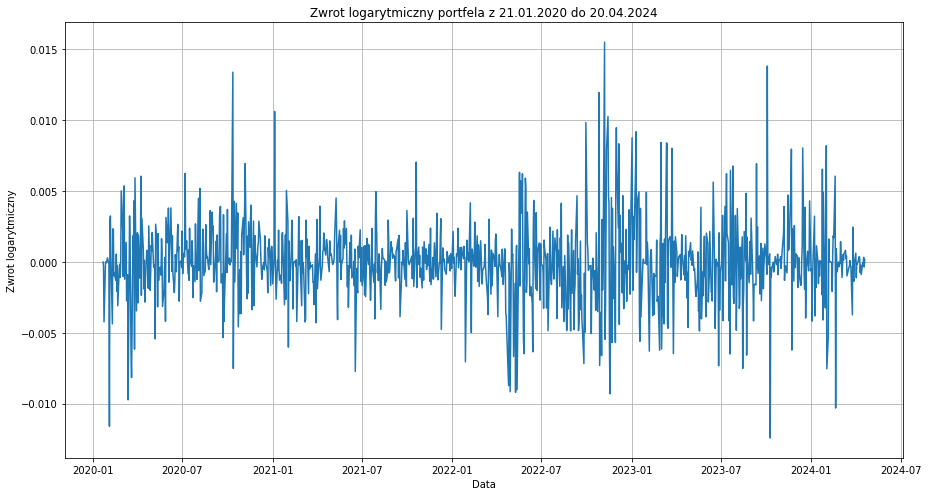

In [628]:
plt.figure(figsize=[13,7])
plt.title('Zwrot logarytmiczny portfela z 21.01.2020 do 20.04.2024')
plt.plot(data['Data'], data['Zwrot'])
plt.xlabel('Data')
plt.ylabel('Zwrot logarytmiczny')
plt.grid(True)
plt.tight_layout()
plt.savefig('zwrot_portfel.png')

### Miary zmienności dla portfela

In [629]:
print("Średnia = ", np.mean(data['Zwrot']))
print("Odchylenie standardowe = ", np.std(data['Zwrot']))
print("Variancja = ", np.var(data['Zwrot']))
print("Rozstęp = ", np.ptp(data['Zwrot']))

odchylenie_przecietne = np.mean(np.abs(data['Zwrot'] - np.mean(data['Zwrot'])))
print("Odchylenie przeciętne = ", odchylenie_przecietne)

srednia = np.mean(data['Zwrot'])
odchylenie_standardowe = np.std(data['Zwrot'], ddof=1)  # ddof=1 oznacza, że obliczamy próbkę
wspolczynnik_zmiennosci = (odchylenie_standardowe / srednia) * 100
print("Współczynnik zmienności = ", wspolczynnik_zmiennosci)


Średnia =  -4.209824244800934e-05
Odchylenie standardowe =  0.0028519531078399774
Variancja =  8.133636529318105e-06
Rozstęp =  0.027941346038255252
Odchylenie przeciętne =  0.0019262686383757905
Współczynnik zmienności =  -6777.577390840408


### Kwantyle

In [630]:
print("Wartóść minimalna = ", min(data['Zwrot']))
print("Kwartyl 0.05 = ", np.quantile(data['Zwrot'], 0.05))
print("Kwartyl 0.25 = ", np.quantile(data['Zwrot'], 0.25))
print("Mediana = ", np.quantile(data['Zwrot'], 0.5))
print("Kwartyl 0.75 = ", np.quantile(data['Zwrot'], 0.75))
print("Kwartyl 0.95 = ", np.quantile(data['Zwrot'], 0.95))
print("Wartóść maxymalna = ", max(data['Zwrot']))

Q1 = np.quantile(data['Zwrot'], 0.25)
Q3 = np.quantile(data['Zwrot'], 0.75)
rozstep_miedzykwartylowy = Q3 - Q1
print("Rozstęp międzykwartylowy = ", rozstep_miedzykwartylowy)


Wartóść minimalna =  -0.012426766262515076
Kwartyl 0.05 =  -0.004689144532577013
Kwartyl 0.25 =  -0.0012918999464085748
Mediana =  -4.5830536093120586e-05
Kwartyl 0.75 =  0.0011502514762831914
Kwartyl 0.95 =  0.004509663836621158
Wartóść maxymalna =  0.015514579775740176
Rozstęp międzykwartylowy =  0.002442151422691766


### Histogram portfelu

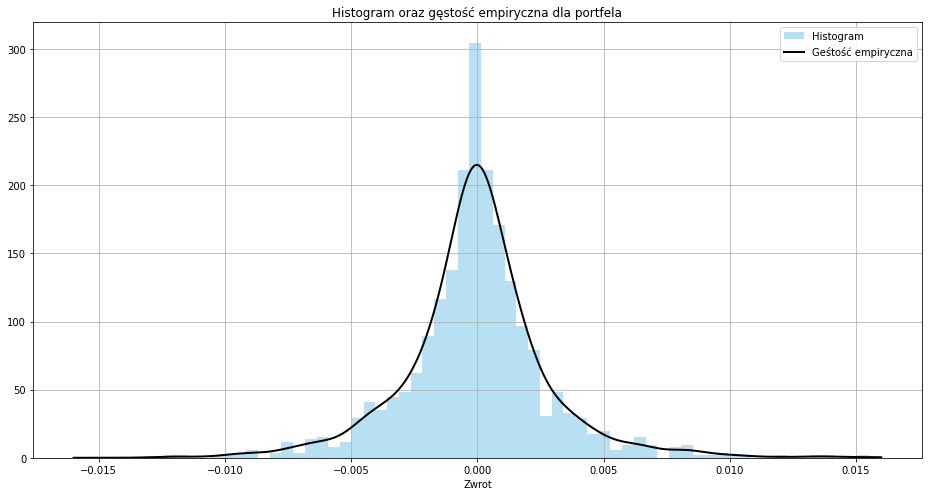

In [631]:
plt.figure(figsize=[13,7])

# Histogram
plt.hist(data['Zwrot'], bins='auto', density=True, alpha=0.6, color='skyblue', label='Histogram')

#Gestość
kde = stats.gaussian_kde(data['Zwrot'])
x = np.linspace(-0.016, 0.016, 10000)
plt.plot(x, kde(x), 'k-', linewidth=2, label = 'Geśtość empiryczna')

plt.title('Histogram oraz gęstość empiryczna dla portfela')
plt.xlabel('Zwrot')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('hist_port.png')

### Dystrybuanta portfelu

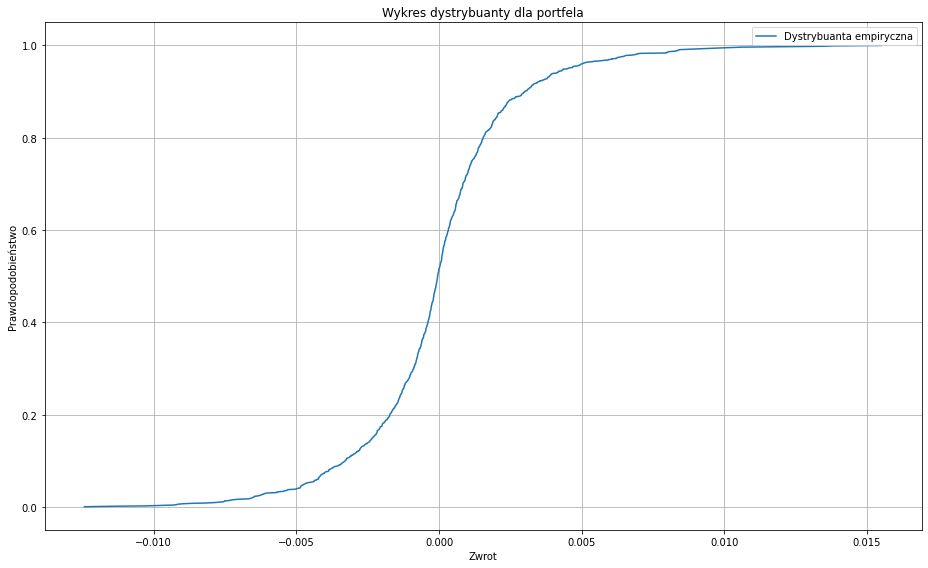

In [632]:
plt.figure(figsize=(13, 8))
dystrybemp=ECDF(data['Zwrot'])
plt.plot(dystrybemp.x, dystrybemp.y, label="Dystrybuanta empiryczna")
plt.title('Wykres dystrybuanty dla portfela')
plt.xlabel('Zwrot')
plt.ylabel('Prawdopodobieństwo')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('dyst_port.png')

$$\mu = -0.0000458 $$
$$b =    0.0019263$$

In [633]:
# Wartość krytyczna
alpha = 0.05
n = len(data['Zwrot'])
critical_value = np.sqrt(-0.5 * np.log(alpha / 2)) / np.sqrt(n)

# Dopasowanie rozkładów
params_normal = stats.norm.fit(data['Zwrot'])
params_t = stats.t.fit(data['Zwrot'])  
params_laplace = stats.laplace.fit(data['Zwrot'])  
params_cauchy = stats.cauchy.fit(data['Zwrot'])   
params_lognorm = stats.lognorm.fit(data['Zwrot']) 

# Test Kołmogorowa-Smirnowa
ks_stat_t, ks_p_t = stats.kstest(data['Zwrot'], 't', args=params_t)
ks_stat_laplacea, ks_p_laplacea = stats.kstest(data['Zwrot'], 'laplace', args=params_laplace)
ks_stat_cauchy, ks_p_cauchy = stats.kstest(data['Zwrot'], 'cauchy', args=params_cauchy)
ks_stat_lognorm, ks_p_lognorm = stats.kstest(data['Zwrot'], 'lognorm', args=params_lognorm)
ks_stat_norm, ks_p_norm = stats.kstest(data['Zwrot'], 'norm', args=params_normal)


# Test Shapiro-Wilka
w_statistic_normal, p_value_normal = stats.shapiro(data['Zwrot'])

print("T-studenta: KS-statystyka =", ks_stat_t, "P-wartość =", ks_p_t)
print("Laplace\'a: KS-statystyka =", ks_stat_laplacea, "P-wartość =", ks_p_laplacea)
print("Cauchy: KS-statystyka =", ks_stat_cauchy, "P-wartość =", ks_p_cauchy)
print("Lognorm: KS-statystyka =", ks_stat_lognorm, "P-wartość =", ks_p_lognorm)
print("Normalny: KS-statystyka =", ks_stat_norm, "P-wartość =", ks_p_norm)
print("Normalny: W-statystyka =", w_statistic_normal, "P-wartość =", p_value_normal)
print(critical_value)


T-studenta: KS-statystyka = 0.02451936228436591 P-wartość = 0.5101910159415994
Laplace'a: KS-statystyka = 0.023941504184884166 P-wartość = 0.5410817370929168
Cauchy: KS-statystyka = 0.03748832528815242 P-wartość = 0.08658818266062085
Lognorm: KS-statystyka = 0.08983921579347359 P-wartość = 3.1256729971192006e-08
Normalny: KS-statystyka = 0.09064344622906928 P-wartość = 2.2622299326551747e-08
Normalny: W-statystyka = 0.9393731355667114 P-wartość = 7.466228336338094e-21
0.04080020580061717


In [634]:
params_laplace

(-4.5830536093120586e-05, 0.0019262627442157975)

Laplace'a

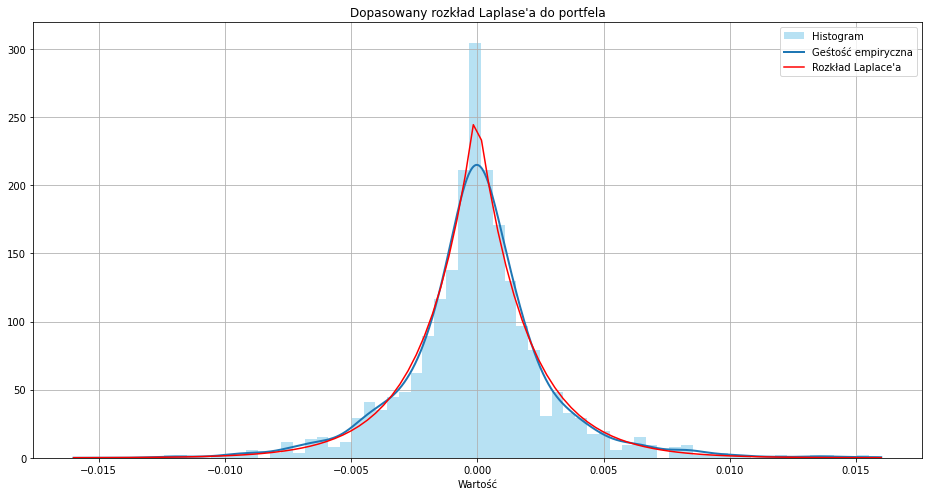

In [635]:
plt.figure(figsize=[13,7])

# Histogram
plt.hist(data['Zwrot'], bins='auto', density=True, alpha=0.6, color='skyblue', label='Histogram')

#Gestość
kde = stats.gaussian_kde(data['Zwrot'])
x = np.linspace(-0.016, 0.016, 10000)
plt.plot(x, kde(x), linewidth=2, label = 'Geśtość empiryczna')

# gęstość teoretyczna
pdf = stats.laplace.pdf(np.linspace(-0.016, 0.016, 100), params_laplace[0], params_laplace[1])
plt.plot(np.linspace(-0.016, 0.016, 100), pdf, label = "Rozkład Laplace\'a ", color = 'red')

plt.title('Dopasowany rozkład Laplase\'a do portfela')
plt.xlabel('Wartość')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('dop_hist_port.png')

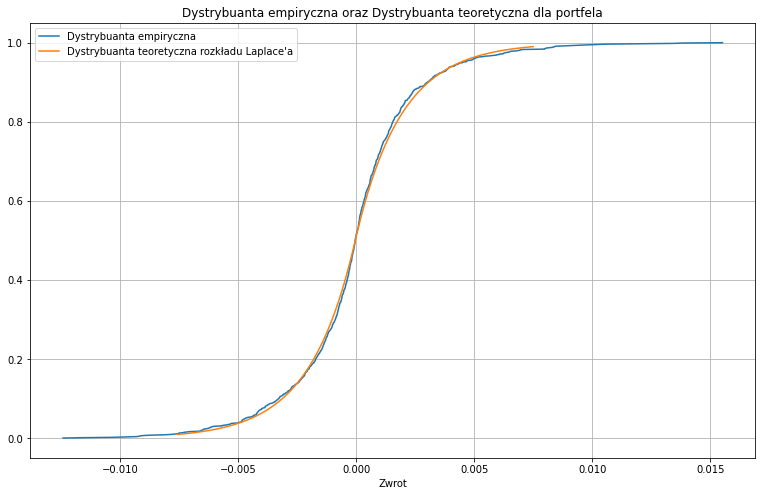

In [636]:
plt.figure(figsize=(13, 8))
plt.plot(dystrybemp.x, dystrybemp.y, label="Dystrybuanta empiryczna")

x = np.linspace(stats.laplace.ppf(0.01, params_laplace[0], params_laplace[1]), stats.laplace.ppf(0.99,params_laplace[0], params_laplace[1]), 100)
plt.plot(x, stats.laplace.cdf(x,params_laplace[0], params_laplace[1]),label="Dystrybuanta teoretyczna rozkładu Laplace\'a")

plt.xlabel('Zwrot')
plt.ylabel('')
plt.title("Dystrybuanta empiryczna oraz Dystrybuanta teoretyczna dla portfela")
plt.legend()
plt.grid('True')
plt.savefig('dop_dyst_port.png')
plt.show()

### Dystrybuanta dwuwymiarowa

In [637]:
df["d_after"] = df[" Open"].shift(-1)
df = df.fillna(df[" Open"].iloc[-1])
df['N'] = np.log(df['d_after']/df[' Open'])
df = df.drop(df.index[-1])
len(df['N']), len(data['log_return'])

(1108, 1108)

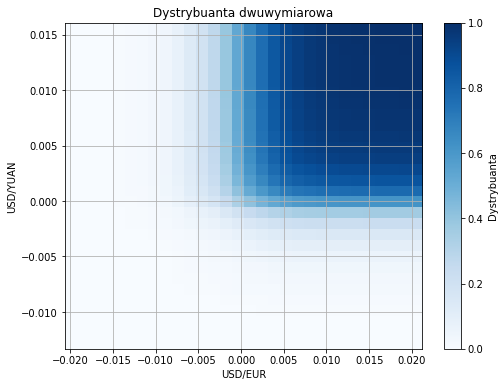

In [638]:
x = data['log_return']
y = df['N']

# Obliczanie dwuwymiarowego histogramu
H, xedges, yedges = np.histogram2d(x, y, bins=30)

# Obliczanie dystrybuanty
cumulative_H = np.cumsum(np.cumsum(H, axis=0), axis=1)

# Normalizacja do przedziału [0,1]
cumulative_H /= np.max(cumulative_H)

# Tworzenie wykresu
plt.figure( figsize=[8,6])
plt.imshow(cumulative_H.T, extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]), origin='lower', cmap='Blues', aspect='auto')
plt.colorbar(label='Dystrybuanta')
plt.xlabel('USD/EUR')
plt.ylabel('USD/YUAN')
plt.title('Dystrybuanta dwuwymiarowa')
plt.grid(True)
plt.savefig('dyst_dwuwym.png')
plt.show()

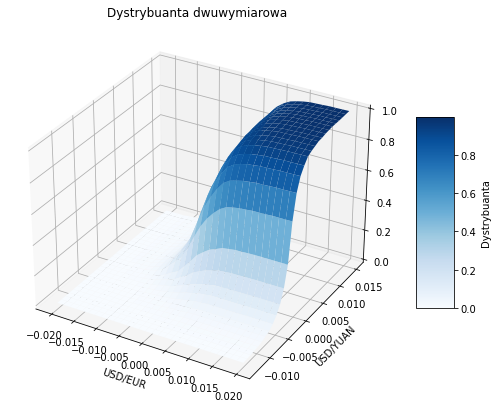

In [639]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Zakładamy, że mamy już wcześniej przygotowane dane w postaci logarytmicznych zwrotów dla USD/EUR i USD/YUAN.
# Przykładowe dane (zastąp je swoimi danymi):
x = data['log_return']
y = df['N']

# Obliczanie dwuwymiarowego histogramu
H, xedges, yedges = np.histogram2d(x, y, bins=30)

# Obliczanie dystrybuanty
cumulative_H = np.cumsum(np.cumsum(H, axis=0), axis=1)

# Normalizacja dystrybuanty do przedziału [0,1]
cumulative_H_normalized = cumulative_H / cumulative_H.max()

# Tworzenie siatki współrzędnych dla wykresu powierzchniowego
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
Z = cumulative_H_normalized.T

# Rysowanie wykresu powierzchniowego
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Użycie 'plot_surface' do narysowania powierzchni
surf = ax.plot_surface(X, Y, Z, cmap='Blues')

# Dodanie colorbaru dla kontekstu
fig.colorbar(surf, shrink=0.5, aspect=5, label='Dystrybuanta')

# Etykiety osi i tytuł
ax.set_xlabel('USD/EUR')
ax.set_ylabel('USD/YUAN')
ax.set_title('Dystrybuanta dwuwymiarowa')
plt.savefig('dyst_port2.png')
plt.show()


In [640]:
len(data['Portfel'])

1108

In [641]:
test_wstecz = data['Zwrot']
gr1 = test_wstecz[:710]
gr2 = test_wstecz[710:]

w_stats, p_value = levene(gr1, gr2,
                          center='mean')
w_stats, p_value

(3.6902625930681783, 0.054987824631327474)

In [642]:
dane = df['N']
gr1 = dane[:710]
gr2 = dane[710:]

w_stats, p_value = levene(gr1, gr2,
                          center='mean')
w_stats, p_value

(3.5503820908710138, 0.05979382697683969)

In [643]:
dane = data['log_return']
gr1 = dane[:710]
gr2 = dane[710:]

w_stats, p_value = levene(gr1, gr2,
                          center='mean')
w_stats, p_value

(3.24016544606851, 0.07212579893548048)

In [646]:
from statsmodels.tsa.stattools import adfuller

# Załóżmy, że `timeseries` to nasza seria czasowa.
result = adfuller(df['N'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -6.888507
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
